In [ ]:
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import yaml
import itertools
import os
import sys
import copy
import collections
from matplotlib.ticker import AutoMinorLocator
from sklearn.cross_validation import KFold
from misc import cm_to_inch, line_split_gen
from fplots.distro import plot_distro
from fplots.plot_utils import MY_PALETTE
from misc import FULL as FULL_ANALYSIS
from misc import SAMPLE as SAMPLE_ANALYSIS
from misc import KEEPK as KEEPK_ANALYSIS
from misc import GEX, WES, CNV, METH
from misc import LKRL, KBMTL, KRR, RF, EN
from misc import KRL as KRL_NONBOLD
KRL = '$\mathcal{%s}$' % KRL_NONBOLD
from misc import METHODS as ALL_METHODS
from misc import open_file
%matplotlib inline
np.random.seed(0)

## Define which configuration and results files to use

In [2]:
# reproduce our paper
CONFIG_FN = os.path.join('paper', 'KEEP5_GEX.yaml')
RESULTS_FN = os.path.join('paper', 'KEEP5_GEX.txt')
CLIN_TRIAL_RESULTS_PREFIX = os.path.join('paper', 'KRL_{}_results.npz')
TCGA_RESULTS_PREFIX = os.path.join('paper', 'KRL_TCGA_BRCA_')

In [ ]:
# plot the results of the GitHub README pipeline
CONFIG_FN = 'config.yaml'
RESULTS_FN = 'results.txt'
CLIN_TRIAL_RESULTS_PREFIX = os.path.join('results', 'KRL_{}_results.npz')
TCGA_RESULTS_PREFIX = os.path.join('results', 'KRL_TCGA_BRCA_')

## Read the config file

In [3]:
with open_file(CONFIG_FN, 'r') as f:
    config = yaml.load(f)

SEEDS = config['seeds']
ANALYSIS = config['analysis']
assert ANALYSIS in [FULL_ANALYSIS, SAMPLE_ANALYSIS, KEEPK_ANALYSIS], 'Unknown analysis type %s specified in the config file' % ANALYSIS
DATA_NAME = config['data']
assert DATA_NAME in [GEX, WES, CNV, METH], 'Unknown data type %s specified in the config file' % DATA_NAME
NUM_FOLDS = config['cv']
SAMPLE_RATIOS = sorted(config['sample_ratios'])[::-1]
KEEPK_RATIOS = sorted(config['keepk_ratios'])[::-1]
K_EVALS = sorted(config['k_evals'])
KEEPK = config['keepk']
METHODS = sorted(config['methods'], key=lambda x: ALL_METHODS.index(x))
for method in METHODS:
    assert method in [KRL_NONBOLD, LKRL, KBMTL, KRR, RF, EN], 'Unknown method %s specified in the config file' % method
    if method == KRL_NONBOLD:
        METHODS[METHODS.index(KRL_NONBOLD)] = KRL

## Define constants

In [4]:
INLINE = True
SINGLE_COL_WIDTH = cm_to_inch(8.6)
DOUBLE_COL_WIDTH = cm_to_inch(17.8)
#MARKERS=['D', '*', '^', 's', 'o']
MARKERS='o'
ABCDEF = 'abcdef'

NUM_SAMPLES = {GEX: 962, WES: 953, CNV: 985, METH: 785}
NDCG = 'NDCG'
PRECISION = 'Precision'
P_THR = 0.05

## Define functions

In [5]:
def parse_results(fn, num_samples=None, means=False, seeds=None, ratios=None):
    #NDCG EN 10000 1 1 0.44800 0.49022 0.45177 0.40200
    results, seeds_set, num_samples_list = {}, set([]), []
    for ls in line_split_gen(fn, delim=' '):
        metric = ls[0]
        if metric in [NDCG.upper(), PRECISION.upper()]:
            s = int(ls[2])
            if seeds is None or s in seeds:
                metric = PRECISION if metric == PRECISION.upper() else NDCG
                m = ls[1] if ls[1] != KRL_NONBOLD else KRL
                seeds_set.add(s)
                r = float(ls[3])
                assert (r >= 0 and r <= 1) or r == -1
                if ratios is None or r in ratios:
                    k = int(ls[4])
                    mean = float(ls[5])
                    values = np.array(ls[6:], dtype=float)
                    assert np.mean(values[~np.isnan(values)]) - mean < 0.001, \
                    ('%s, %s' % (np.mean(values[~np.isnan(values)]), mean))
                    assert num_samples is None or values.shape[0] == num_samples \
                    or values.shape[0] in [962, 925, 957, 765], \
                    '{}, {}, {}, {}, {}, {}'.format(m, values.shape, s, r, k, fn)
                    num_samples_list.append(values.shape[0])
                    order = reorder(values.shape[0], NUM_FOLDS, s)

                    if m not in results: results[m] = {}
                    if k not in results[m]: results[m][k] = {}
                    if r not in results[m][k]: results[m][k][r] = {}
                    if metric not in results[m][k][r]: results[m][k][r][metric] = []
                    results[m][k][r][metric].extend(values[order] if not means else [mean])
    
    print 'Number of seeds: {}; number of samples: {}'.format(len(seeds_set),
          ', '.join(map(str, num_samples_list)) if num_samples is None else num_samples)

    return results

def reorder(n, nfold, seed):
    kf = list(KFold(n, nfold, shuffle=True, random_state=seed))
    for fold in range(nfold):
        train_index, test_index = kf[fold]
        if fold == 0:
            index_seed = test_index
        else:
            index_seed = np.append(index_seed, test_index)
    return np.argsort(index_seed)

def mean_std(stat_data, num_samples, axis=1):
    assert len(stat_data) % num_samples == 0, \
    '{}, {}'.format(len(stat_data), num_samples)
    new_data = []
    for i in range(0, len(stat_data), num_samples):
        new_data.append(stat_data[i:i + num_samples])
    new_data = np.array(new_data)
    
    if axis == 0:
        std_list = []
        for i in range(new_data.shape[1]):
            sample = new_data[:, i]
            std_list.append(np.std(sample[~np.isnan(sample)]))
        mean_std = np.mean(std_list)
    else:
        mean_list = []
        for i in range(new_data.shape[0]):
            seed = new_data[i, :]
            mean_list.append(np.mean(seed[~np.isnan(seed)]))
        mean_std = np.std(mean_list)
    mean = np.mean(stat_data)
    return [mean - mean_std, mean + mean_std]

def make_long_dictionary(results, methods=None, k_range=None, r_range=None, r_transform=None):
    long_data = {'k': [], 'r': [], 'method': [], NDCG: [], PRECISION: []}
    for method in (results if methods is None else methods):
        for k in (results[method] if k_range is None else k_range):
            for r in (results[method][k] if r_range is None else r_range):
                for ndcg, precision in zip(results[method][k][r][NDCG], results[method][k][r][PRECISION]):
                    long_data['method'].append(method)
                    long_data['k'].append(k)
                    long_data['r'].append(r_transform(r) if r_transform is not None else r)
                    long_data[NDCG].append(ndcg)
                    long_data[PRECISION].append(precision)
    return long_data

def parse_ranks(fn, methods, seeds=None, ratios=None):
    #RANK EN 10000 1 1.841995842 1 1 2 4
    ranks_dict = {}
    for ls in line_split_gen(fn, delim=' '):
        if ls[0] == 'RANK':
            s = int(ls[2])
            r = float(ls[3])
            if (seeds is None or s in seeds) and (ratios is None or r in ratios):
                m = ls[1] if ls[1] != KRL_NONBOLD else KRL
                mean_rank = float(ls[4])
                ranks = map(int, ls[5:])
                assert np.all([rank >=1 and rank <= len(methods) for rank in ranks])
                if r not in ranks_dict: ranks_dict[r] = {}
                if m not in ranks_dict[r]: ranks_dict[r][m] = []
                new_ranks = [len(methods) - r_cumul + 1 for r_cumul in range(1, len(methods)+1) for rank in ranks if rank <= r_cumul]
                ranks_dict[r][m].extend(new_ranks)
    
    ranks_df = {'method': [], 'mrank': [], 'ratio': []}
    for method in methods:
        yrange = None
        for ratio in ranks_dict:
            for rank in ranks_dict[ratio][method]:
                ranks_df['method'].append(methods.index(method))
                ranks_df['mrank'].append(rank)
                ranks_df['ratio'].append(ratio)
            yrange = ranks_dict[ratio][method].count(1) if yrange is None else yrange
            assert yrange == ranks_dict[ratio][method].count(1)
    df = pd.DataFrame.from_dict(ranks_df)
    return df, yrange, sorted(ranks_dict.keys())

def parse_perc(fn, methods=None, seeds=None, ratios=None):
    #PERCENTILE EN 10000 1 1 1 0.010989010989
    records, rs = [], set([])
    convert = lambda x: [x[0], x[1] if x[1] != KRL_NONBOLD else KRL, int(x[2]), float(x[3]), int(x[4]), int(x[5]), float(x[6])]
    columns = ['format', 'method', 'seed', 'r', 'k_perc', 'i', 'p']
    for ls in line_split_gen(fn, delim=' '):
        if ls[0] == 'PERCENTILE':
            s = int(ls[2])
            r = float(ls[3])
            m = ls[1] if ls[1] != KRL_NONBOLD else KRL
            if (seeds is None or s in seeds) and (ratios is None or r in ratios) and (methods is None or m in methods):
                records.append(convert(ls))
                rs.add(r)
    df = pd.DataFrame.from_records(sorted(records, key=lambda x: methods.index(x[1])), columns=columns)
    return df, sorted(rs)

def sort_methods(results, order=METHODS, reverse=False):
    return sorted(results.keys(), key=lambda m: order.index(m), reverse=reverse)

In [6]:
def ttest(results, method1, method2, ks=None, rs=None, metrics=None):
    pvalues = {}
    for k in (ks if ks is not None else results[method1]):
        pvalues[k] = {}
        for r in (rs if rs is not None else results[method1][k]):
            pvalues[k][r] = {}
            for metric in (metrics if metrics is not None else results[method1][k][r]):
                values1 = np.array(results[method1][k][r][metric])
                values2 = np.array(results[method2][k][r][metric])
                assert values1.shape == values2.shape
                _, p = scipy.stats.ttest_rel(values1, values2)
                pvalues[k][r][metric] = (p, np.mean(values1) - np.mean(values2), method1, method2)
    return pvalues

def strip_math(s):
    if s[0] == '$' and s[-1] == '$' and  '{' in s and '}' in s:
        s = s[s.find('{') + 1 : s.rfind('}')]
    return s

def print_pvalues(pvalues, ks=None, rs=None, thr=P_THR):
    for k in ks:
        for r in rs:
            pvals = []
            for metric in pvalues[k][r]:
                pval, diff, method1, method2 = pvalues[k][r][metric]
                pvals.append([metric, pval, diff])
            print '{} vs {:<5}  k {:<2}  r {:<4}  {}'.format( \
                   strip_math(method1), strip_math(method2), k, r,
                   '  '.join(map(lambda x: \
                        '{}  p {:<7.4f}  diff {:<8.5f} {:<1} {:<1}'.format( \
                        x[0], x[1], x[2], '*' if x[1] < thr else ' ', '!' if x[2] < 0 else ' '), pvals)))
    
def print_results(results, methods=None, ks=None, rs=None, metrics=None):
    means = None
    for method in (methods if methods is not None else results):
        if means is not None: print ''
        for k in (ks if ks is not None else results[method]):
            for r in (rs if rs is not None else results[method][k]):
                means = []
                for metric in (metrics if metrics is not None else results[method][k][r]):
                    means.append([metric, np.mean(results[method][k][r][metric])])
                print '{:<5}  k {:<2}  r {:<4}  {}'.format( \
                       strip_math(method), k, r,
                       '  '.join(map(lambda x: '{}  {:.5f}'.format(x[0], x[1]), means)))
                        
def print_summary(results, methods_to_compare, methods=None, ks=None, rs=None, metrics=None, short=False):
    if not short:
        print_results(results, methods, ks, rs, metrics)
    print ''
    for method in methods_to_compare:
        if method != KRL:
            pvalues = ttest(results, KRL, method, ks, rs, metrics)
            print_pvalues(pvalues, ks, rs)
            print ''
    
def rank_one_fraction(ranks_df, methods, method, ratio):
    count = ranks_df[(ranks_df.method==methods.index(method)) & \
                                    (ranks_df.mrank==len(methods)) & \
                                    (ranks_df.ratio==ratio)].shape[0]
    return count / float(NUM_SAMPLES[DATA_NAME])

def top_perc_fraction(hist_df, methods, method, ratio):
    arr = hist_df[(hist_df.k_perc==K_PERC) & \
             (hist_df.r==ratio) & \
             (hist_df.method==method) & \
             (~np.isnan(hist_df.p))].p.values
    hist, bin_edges = np.histogram(arr, bins=np.arange(0, 1.01, 0.1))
    assert np.all(list(bin_edges) == np.arange(0, 1.01, 0.1))
    return hist[0] / float(arr.shape[0])

def print_df_stats(parse_method, count_method, results_fn, methods, seeds, ratios):
    for r in ratios:
        counts = {}
        for method in methods:
            counts[method] = []

        for seed in seeds:
            df_tuple = parse_method(results_fn, methods, [seed], ratios)
            df = df_tuple[0]
            for method in methods:
                count = count_method(df, methods, method, r)
                counts[method].append(count)

        for method in methods[::-1]:
            if method != KRL:
                _, p = scipy.stats.ttest_rel(counts[KRL], counts[method])
                assert len(counts[KRL]) == len(counts[method])
                krl_mean = np.mean(counts[KRL])
                method_mean = np.mean(counts[method])

                print '{} vs {:<5}  r {:<4}  p {:<7.4f}  diff {:<8.5f} {:<1} {:<1}  {}  {:.4g} {:<5}  {:.4g}' \
                       .format(strip_math(KRL), strip_math(method), r,
                       p, krl_mean - method_mean,
                       '*' if p < P_THR else ' ',
                       '!' if krl_mean < method_mean else ' ',
                       strip_math(KRL), krl_mean, strip_math(method), method_mean)
        print ''

In [7]:
def set_fonts(fontsize):
    mpl.rcParams['font.family'] = 'sans-serif'
    mpl.rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
    normal = mpl.font_manager.FontProperties(fname='fplots/fonts/Helvetica.ttf', weight='normal', size=fontsize)
    bold = mpl.font_manager.FontProperties(fname='fplots/fonts/HelveticaBold.ttf', weight='bold', size=fontsize)
    italic = mpl.font_manager.FontProperties(fname='fplots/fonts/Helvetica.ttf', weight='normal', style='italic', size=fontsize)
    bold_italic = mpl.font_manager.FontProperties(fname='fplots/fonts/HelveticaBoldOblique.ttf', weight='normal', style='italic', size=fontsize)
    return normal, bold, italic, bold_italic

def get_fig_size(titles=True, double_col=False, height=None):
    if height is None:
        height = 6.5 if titles else 5.7
    return (SINGLE_COL_WIDTH * (2 if double_col else 1), cm_to_inch(height))

def get_output_fn(plot, analysis, metric, keepk, keval=None, ratio=None):
    assert keval is None or ratio is None
    var = '_k' if keval is not None else ('_r' if ratio is not None else '')
    val = keval if keval is not None else (ratio if ratio is not None else '')
    return '{}_{}_{}{}.pdf'.format(analysis + str(keepk) if analysis == KEEPK_ANALYSIS else '', plot, metric, '{}{}'.format(var, val))

In [8]:
def make_bold(text):
    return '$\mathcal{%s}$' % text

def make_italics(text):
    return '$\mathit{%s}$' % text

def make_bold_italics(text):
    return '$\mathbf{%s}$' % text

## Define labels for the different types of plost/analyses

In [9]:
Q = make_bold_italics('q\,')
R = make_bold_italics('r\,')

In [10]:
xlabel_kevals = 'Evaluation parameter {}'.format(make_bold_italics('k'))
xlable_fraction = 'Fraction of training data'

if ANALYSIS == FULL_ANALYSIS:
    num_samples = NUM_FOLDS
    ratios = [1]
    title_kevals = 'FULL: full training data'
    title_pointplot = title_kevals
    xlabel_pointplot = xlable_fraction
    title_ranks = 'Full training data'
else:
    num_samples = NUM_SAMPLES[DATA_NAME]
    if ANALYSIS == SAMPLE_ANALYSIS:
        ratios = SAMPLE_RATIOS
        title_kevals = 'SAMPLE: training data subsampled to {0:g}%'
        title_pointplot = 'SAMPLE: subsampling training data'
        xlabel_pointplot = xlable_fraction
        title_ranks = 'Training: subsampled to {0:g}%'
    elif ANALYSIS == KEEPK_ANALYSIS:
        ratios = KEEPK_RATIOS
        title_kevals = 'KEEPK: sampling {2} drugs ({3})\nfrom cell line\'s {0:g}% most effective drugs ({1})'
        title_pointplot = 'KEEPK: sampling {0} drugs ({1})\nfrom cell line\'s most effective drugs'
        xlabel_pointplot = 'Fraction of most effective drugs ({0})'
        title_ranks = 'Training: {3} = {2}, {1} = {0:g}%'

## Read the results

In [11]:
results = parse_results(RESULTS_FN, num_samples, ANALYSIS != FULL_ANALYSIS, SEEDS, ratios)

Number of seeds: 10; number of samples: 962


In [12]:
print '*** MEAN NDCG AND PRECISION ***\n'
print_summary(results, methods_to_compare=METHODS[::-1], methods=METHODS[::-1], ks=K_EVALS, rs=ratios)

*** MEAN NDCG AND PRECISION ***

KRL    k 1   r 1.0   NDCG  0.31880  Precision  0.11993
KRL    k 1   r 0.5   NDCG  0.30618  Precision  0.11962
KRL    k 1   r 0.2   NDCG  0.36631  Precision  0.15101
KRL    k 1   r 0.1   NDCG  0.34398  Precision  0.14538
KRL    k 3   r 1.0   NDCG  0.34268  Precision  0.17100
KRL    k 3   r 0.5   NDCG  0.34054  Precision  0.18629
KRL    k 3   r 0.2   NDCG  0.38808  Precision  0.22354
KRL    k 3   r 0.1   NDCG  0.38221  Precision  0.22562
KRL    k 5   r 1.0   NDCG  0.35819  Precision  0.17880
KRL    k 5   r 0.5   NDCG  0.36524  Precision  0.20591
KRL    k 5   r 0.2   NDCG  0.40262  Precision  0.22677
KRL    k 5   r 0.1   NDCG  0.39802  Precision  0.22922
KRL    k 10  r 1.0   NDCG  0.38884  Precision  0.20148
KRL    k 10  r 0.5   NDCG  0.39835  Precision  0.22546
KRL    k 10  r 0.2   NDCG  0.42725  Precision  0.23744
KRL    k 10  r 0.1   NDCG  0.42816  Precision  0.23730
KRL    k 15  r 1.0   NDCG  0.41279  Precision  0.22000
KRL    k 15  r 0.5   NDCG  0.417

## Barplot with x-axis as the evalution parameter _k_

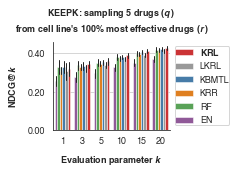

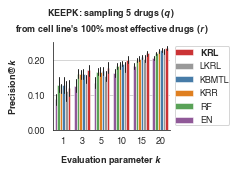

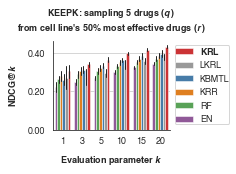

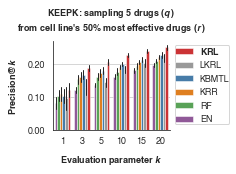

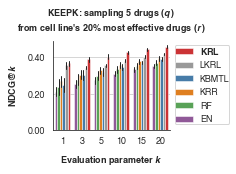

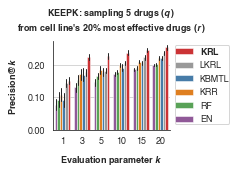

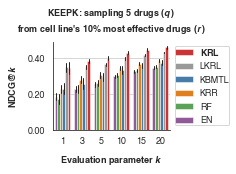

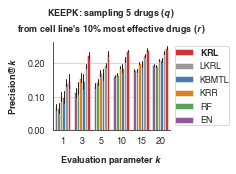

In [13]:
for r in ratios:
    data = make_long_dictionary(results, r_range=[r])
    
    for metric, y_range, y_tics in [(NDCG, None, None), (PRECISION, None, None)]:
        plot_distro((data['k'], data[metric], data['method']),
            bar_plot=True,
            title=title_kevals.format(r * 100, R, KEEPK, Q), x_label=xlabel_kevals,
            ci='sd', capsize=0,
            y_label='{}@{}'.format(metric, make_bold_italics('k')),
            y_range=y_range, y_tics=y_tics,
            rotate_x_tics=0, bold_x_tics=False, hide_x_tick_marks=True,
            legend_out=True, legend_out_pad=0,
            bar_kwargs=dict(errcolor='0.15', errwidth=1, edgecolor='white'),
            order=sorted(set(data['k'])), hue_order=sort_methods(results),
            output=get_output_fn('barplot_kevals', ANALYSIS, metric, KEEPK, ratio=r) if not INLINE else None,
            figsize=get_fig_size(), fontsize=9, linewidth=0.5,
            fig_padding=0.02, reverse_palette=True, ncolours=len(results))

## Pointplot with x-axis as the ratio used for subsampling

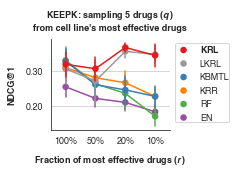

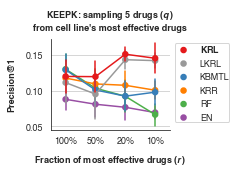

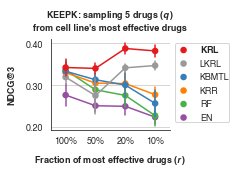

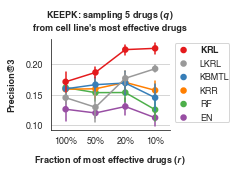

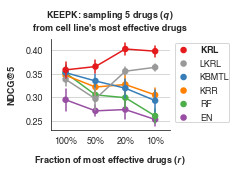

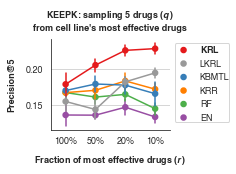

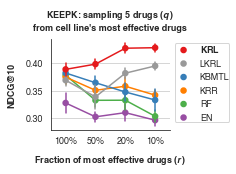

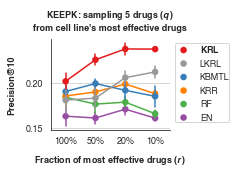

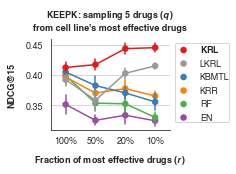

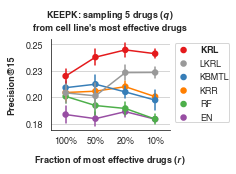

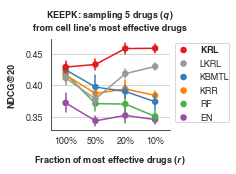

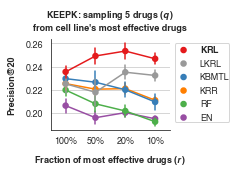

In [14]:
for k in K_EVALS:
    data = make_long_dictionary(results, k_range=[k], r_transform=lambda x: '{:g}%'.format(x * 100))
    
    for metric, y_range, y_tics in [(NDCG, None, None), (PRECISION, None, None)]:
        plot_distro((data['r'], data[metric], data['method']),
            point_plot=True,
            title=title_pointplot.format(KEEPK, Q), x_label=xlabel_pointplot.format(R),
            ci='sd', capsize=0,
            y_label='{}@{}'.format(metric, k),
            y_range=y_range, y_tics=y_tics,
            rotate_x_tics=0, bold_x_tics=False, hide_x_tick_marks=False,
            legend_out=True, legend_out_pad=0,
            point_markers=MARKERS, point_marker_size=20, linewidth=1.5,
            point_kwargs=dict(errwidth=1),
            order=sorted(set(data['r']), key=lambda x: float(x.rstrip('%')), reverse=True),
            hue_order=sort_methods(results),
            output=get_output_fn('pointplot_ratios', ANALYSIS, metric, KEEPK, keval=k) if not INLINE else None,
            figsize=get_fig_size(), fontsize=9,
            fig_padding=0.02, reverse_palette=True, ncolours=len(results))

## Pointplot with x-axis as the evalution parameter _k_

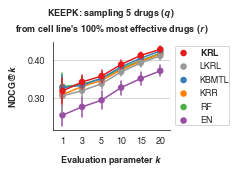

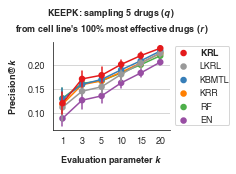

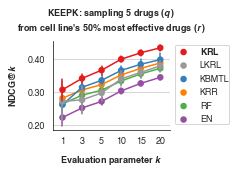

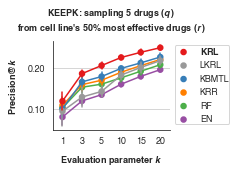

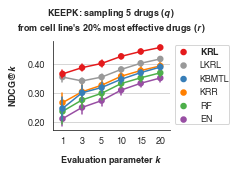

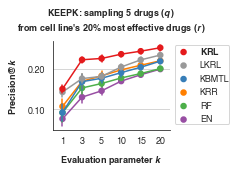

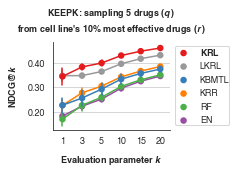

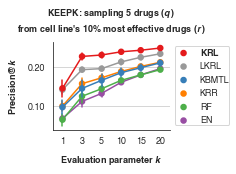

In [15]:
for r in ratios:
    data = make_long_dictionary(results, r_range=[r])
    
    for metric, y_range, y_tics in [(NDCG, None, None), (PRECISION, None, None)]:
        plot_distro((data['k'], data[metric], data['method']),
            point_plot=True,
            title=title_kevals.format(r * 100, R, KEEPK, Q), x_label=xlabel_kevals,
            ci='sd', capsize=0,
            y_label='{}@{}'.format(metric, make_bold_italics('k')),
            y_range=y_range, y_tics=y_tics,
            rotate_x_tics=0, bold_x_tics=False, hide_x_tick_marks=False,
            legend_out=True, legend_out_pad=0,
            point_markers=MARKERS, point_marker_size=20, linewidth=1.5,
            point_kwargs=dict(),
            order=sorted(set(data['k'])), hue_order=sort_methods(results),
            output=get_output_fn('pointplot_kevals', ANALYSIS, metric, KEEPK, ratio=r) if not INLINE else None,
            figsize=get_fig_size(), fontsize=9,
            fig_padding=0.02, reverse_palette=True, ncolours=len(results))

## Method-rank evaluation

In [16]:
normal, bold, italic, bold_italic = set_fonts(fontsize=9)
sns.set_style('ticks', {'axes.linewidth': 0.9, 'linewidth': 0.9,
                        'axes.edgecolor': '0.15',
                        'xtick.minor.size': 0, 'xtick.major.size': 0,
                        'ytick.minor.size': 2, 'ytick.major.size': 4})
sns.set_palette(sns.color_palette('RdBu_r', len(METHODS)))
COL_WRAP = 2

In [17]:
ranks_df, yrange, _ = parse_ranks(RESULTS_FN, METHODS[::-1], SEEDS, ratios)

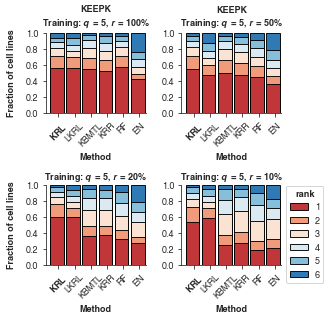

In [18]:
kws = dict(bins=range(len(METHODS)+1), kde=False, hist_kws=dict(alpha=1, linewidth=0.9, rwidth=0.85, edgecolor='black'))
g = sns.FacetGrid(ranks_df, col='ratio', hue='mrank', col_order=ratios,
                  col_wrap=COL_WRAP, sharex=False, sharey=False, height=SINGLE_COL_WIDTH / 1.65)
g = g.map(sns.distplot, 'method', **kws)
g.fig.subplots_adjust(hspace=0.9, wspace=0.35)

g.set_titles(fontproperties=bold)
g.set_ylabels('Fraction of cell lines', fontproperties=bold, labelpad=10)

for i, ax in enumerate(g.axes.flat):
    if i == len(g.axes.flat) - 1:
        legend_handles, legend_labels = ax.get_legend_handles_labels()
        legend=ax.legend(legend_handles[::-1], legend_labels, title='rank', prop=normal, bbox_to_anchor=(1, 1.05))
        plt.setp(legend.get_title(), fontproperties=bold)
        
    ax.set_ylim(0, yrange)
    ax.set_yticks(np.arange(0, yrange + 1, yrange / 5.0))
    ax.set_yticklabels(['%.1f' % x for x in np.arange(0, 1.01, 0.2)], fontproperties=normal)
    ax.set_xlim(-0.2, len(METHODS) + 0.01)
    ax.set_xticks(np.arange(0.59, len(METHODS) + 0.01))
    ax.set_xticklabels(METHODS[::-1], rotation=45, fontproperties=normal)
    ax.tick_params(axis='x', pad=4)
    ax.set_xlabel('Method', fontproperties=bold, labelpad=5)
    title = title_ranks.format(float(ratios[i]) * 100, R, KEEPK, Q)
    ax.set_title('{}{}'.format('{}\n'.format(ANALYSIS) if i < COL_WRAP else '', title), fontproperties=bold, y=1.0)

sns.despine(top=True, right=True, left=False, bottom=False)

if not INLINE:
    plt.savefig(get_output_fn('rankplot', ANALYSIS, metric, KEEPK), bbox_inches='tight', pad_inches=0.02)

In [19]:
print '*** MEAN RANK=1 FREQUENCY ***\n'
print_df_stats(parse_ranks, rank_one_fraction, RESULTS_FN, METHODS, SEEDS, ratios)

*** MEAN RANK=1 FREQUENCY ***

KRL vs LKRL   r 1.0   p 0.9932   diff -0.00021   !  KRL  0.5691 LKRL   0.5693
KRL vs KBMTL  r 1.0   p 0.2312   diff 0.01632       KRL  0.5691 KBMTL  0.5528
KRL vs KRR    r 1.0   p 0.0066   diff 0.03960  *    KRL  0.5691 KRR    0.5295
KRL vs RF     r 1.0   p 0.8321   diff -0.00374   !  KRL  0.5691 RF     0.5729
KRL vs EN     r 1.0   p 0.0000   diff 0.14636  *    KRL  0.5691 EN     0.4228

KRL vs LKRL   r 0.5   p 0.0792   diff 0.06809       KRL  0.5449 LKRL   0.4768
KRL vs KBMTL  r 0.5   p 0.0004   diff 0.05010  *    KRL  0.5449 KBMTL  0.4948
KRL vs KRR    r 0.5   p 0.0020   diff 0.07370  *    KRL  0.5449 KRR    0.4712
KRL vs RF     r 0.5   p 0.0000   diff 0.09823  *    KRL  0.5449 RF     0.4467
KRL vs EN     r 0.5   p 0.0000   diff 0.18254  *    KRL  0.5449 EN     0.3624

KRL vs LKRL   r 0.2   p 0.9760   diff 0.00062       KRL  0.5975 LKRL   0.5969
KRL vs KBMTL  r 0.2   p 0.0000   diff 0.22900  *    KRL  0.5975 KBMTL  0.3685
KRL vs KRR    r 0.2   p 0.0000 

## Histograms of top recommendations

In [20]:
hist_methods = sorted([KRL, KBMTL], key=lambda x: ALL_METHODS.index(x if x != KRL else KRL_NONBOLD))
sns.set_palette([MY_PALETTE[2], MY_PALETTE[0]])
normal, bold, italic, bold_italic = set_fonts(fontsize=9)
sns.set_style('white', {'axes.linewidth': 0.9, 'axes.edgecolor': '0.15',
               'xtick.minor.size': 2, 'xtick.major.size': 4, 'ytick.minor.size': 2,
               'ytick.major.size': 4, 'linewidth': 0.9})
COL_WRAP = 2
K_PERC = 1

In [21]:
hist_df, _ = parse_perc(RESULTS_FN, hist_methods, SEEDS, ratios)
hist_df.loc[:, 'p'] = (1 - hist_df.loc[:, 'p']) * 100

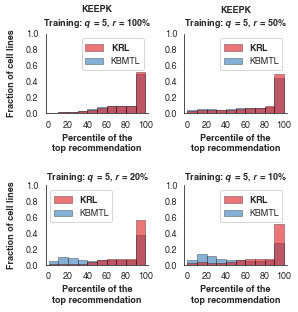

In [22]:
g = sns.FacetGrid(hist_df[hist_df.k_perc == K_PERC], col_wrap=COL_WRAP, col='r', hue='method', col_order=ratios,
                  sharex=False, sharey=False, height=SINGLE_COL_WIDTH/1.65)
kws = dict(bins=np.arange(0,101,10), kde=False,
           hist_kws=dict(alpha=0.6, linewidth=0.5, rwidth=1, edgecolor='black'))
g = g.map(sns.distplot, 'p', **kws)
g.fig.subplots_adjust(hspace=0.9, wspace=0.35)

g.set_titles(fontproperties=bold)
g.set_ylabels('Fraction of cell lines', fontproperties=bold, labelpad=10)

handles, labels = g.axes.flat[0].get_legend_handles_labels()
num_pred = None
for i, ax in enumerate(g.axes.flat):
    ax.set_xlabel('Percentile of the\ntop recommendation', fontproperties=bold)
    num_pred = hist_df[(hist_df.k_perc == K_PERC) \
                       & (hist_df.r == ratios[i]) \
                       & (~np.isnan(hist_df.p))].shape[0] / float(len(hist_methods))
    legend_handles, legend_labels = ax.get_legend_handles_labels()
    legend=ax.legend(legend_handles[::-1], legend_labels[::-1], prop=normal, markerscale=5)
    ax.set_yticklabels(ax.get_yticklabels(), fontproperties=normal)
    ax.set_ylim(0, num_pred + 1)
    ax.set_yticks(np.arange(0, num_pred + 1, num_pred / 5.0))
    ax.set_yticklabels(['{:.1f}'.format(float(x) / num_pred) for x in np.arange(0, num_pred + 1, num_pred / 5.0)],
                       fontproperties=normal)
    ax.set_xlim(-3, 103)
    ax.set_xticks(np.arange(0, 101, 20))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.set_xticklabels(['{:g}'.format(x) for x in np.arange(0, 101, 20)], fontproperties=normal)
    title = title_ranks.format(float(ratios[i]) * 100, R, KEEPK, Q)
    ax.set_title('{}{}'.format('{}\n'.format(ANALYSIS) if i < COL_WRAP else '', title), fontproperties=bold, y=1.0)

sns.despine(top=True, right=True, left=False, bottom=False)

if not INLINE:
    plt.savefig(get_output_fn('histplot', ANALYSIS, metric, KEEPK), bbox_inches='tight', pad_inches=0.02)

In [23]:
print '*** MEAN TOP 10% OF DRUGS FREQUENCY ***\n'
print_df_stats(parse_perc, top_perc_fraction, RESULTS_FN, METHODS, SEEDS, ratios)

*** MEAN TOP 10% OF DRUGS FREQUENCY ***

KRL vs LKRL   r 1.0   p 0.9696   diff 0.00102       KRL  0.5121 LKRL   0.511
KRL vs KBMTL  r 1.0   p 0.4198   diff 0.01269       KRL  0.5121 KBMTL  0.4994
KRL vs KRR    r 1.0   p 0.0306   diff 0.03162  *    KRL  0.5121 KRR    0.4804
KRL vs RF     r 1.0   p 0.9145   diff 0.00218       KRL  0.5121 RF     0.5099
KRL vs EN     r 1.0   p 0.0004   diff 0.11078  *    KRL  0.5121 EN     0.4013

KRL vs LKRL   r 0.5   p 0.0280   diff 0.07154  *    KRL  0.4905 LKRL   0.419
KRL vs KBMTL  r 0.5   p 0.0001   diff 0.04556  *    KRL  0.4905 KBMTL  0.445
KRL vs KRR    r 0.5   p 0.0003   diff 0.05991  *    KRL  0.4905 KRR    0.4306
KRL vs RF     r 0.5   p 0.0000   diff 0.09601  *    KRL  0.4905 RF     0.3945
KRL vs EN     r 0.5   p 0.0000   diff 0.15364  *    KRL  0.4905 EN     0.3369

KRL vs LKRL   r 0.2   p 0.8189   diff 0.00386       KRL  0.5614 LKRL   0.5576
KRL vs KBMTL  r 0.2   p 0.0000   diff 0.18543  *    KRL  0.5614 KBMTL  0.376
KRL vs KRR    r 0.2   p 0

## Clinical data

In [24]:
TCGA_DATA = os.path.join('data', 'KRL_data_for_TCGA_BRCA.npz')
TCGA_BRCA_CLINICAL = os.path.join('data', 'TCGA_BRCA_clinical.csv.gz')

## Clinical trials

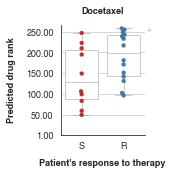

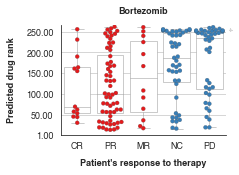

In [25]:
from misc import DOCETAXEL, BORTEZOMIB

normal, bold, italic, bold_italic = set_fonts(fontsize=9)
NUM_DRUGS = 265
ytic_step = 50
y_tics = [1] + range(ytic_step, NUM_DRUGS+1, ytic_step)
width, height = get_fig_size()
for drug, order, binary in [(DOCETAXEL, ['S', 'R'], True),
                    (BORTEZOMIB, ['CR', 'PR', 'MR', 'NC', 'PD'], False)]:
    data = np.load(CLIN_TRIAL_RESULTS_PREFIX.format(drug))
    drug_ranks = data['drug_ranks']
    test_y = data['test_y'] if drug != DOCETAXEL else ['S' if y == 1 else 'R' for y in data['test_y']]
    binary_test_y = data['binary_test_y']

    plot_distro((test_y, drug_ranks, None),
        swarm_plot=True, box_plot=True,
        box_outlier=0, box_notch=False,
        box_kwargs=dict(color='white'),
        swarm_kwargs=dict(size=4, edgecolor='gray', linewidth=0.2),
        order=order,
        y_range=(1, NUM_DRUGS + 1),
        y_tics=y_tics,
        y_label='Predicted drug rank', x_label='Patient\'s response to therapy',
        legend_out=True, legend_out_pad=0,
        figsize=(width / 1.5 if binary else width, height), fontsize=9, linewidth=0.5,
        title='{}{}'.format(drug[0].upper(), drug[1:].lower()),
        fig_padding=0.02, palette=[MY_PALETTE[0], MY_PALETTE[2]] if binary else [MY_PALETTE[0], MY_PALETTE[0], MY_PALETTE[0], MY_PALETTE[2], MY_PALETTE[2]])

## TCGA breast cancer (BRCA) cohort

In [26]:
from results_TCGA import tcga_results

data = np.load(TCGA_DATA)
test_ids = data['test_ids']
brca_df = pd.read_csv(TCGA_BRCA_CLINICAL, index_col=0)
tcga_results(brca_df=brca_df, pred_prefix=TCGA_RESULTS_PREFIX, test_ids=test_ids,
             lambdas=[1e-05], gamma=3.1e-05, k=10, nfolds=3, verbose=False)

HER2+: 163
TNBC mBRCA: 9
TNBC JAK2+: 56

------------------------------------------------------------------
| Recommendation          | HER2+      | TNBC mBRCA | TNBC JAK2+ |
------------------------------------------------------------------
| lapatinib > PARPi       | 0.91       | 0.11       | ---        |
| lapatinib > veliparib   | 0.95       | 0.22       | ---        |
| lapatinib > olaparib1   | 0.95       | 0.44       | ---        |
| lapatinib > olaparib2   | 0.93       | 0.33       | ---        |
| lapatinib > talazoparib | 0.92       | 0.22       | ---        |
| lapatinib > rucaparib   | 0.94       | 0.44       | ---        |
| lapatinib > ruxolitinib | 0.86       | ---        | 0.29       |
------------------------------------------------------------------
